In [228]:
import sympy as sp
import numpy as np
from IPython.display import display, Math
import matplotlib.pyplot as plt

z = sp.Symbol("z", complex = True)
n, k, j, n_0 = sp.symbols("n k j n_0", integer = True)
N = 200

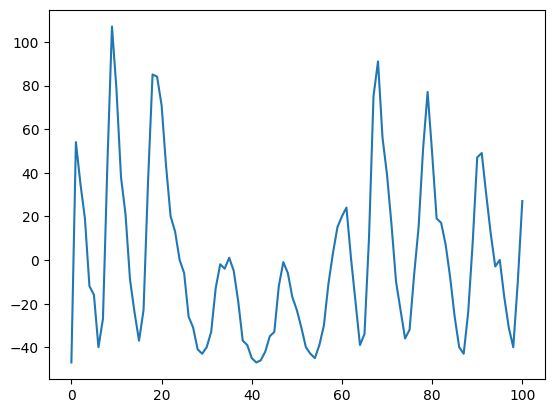

In [229]:
# Insertar phi y theta
mu = 46.93
phi = 1 - 1.317 * z + 0.634 * z**2
theta = 1
sigma = 17.008821240756223 # standard deviation
X = np.array([
    0, 101, 82, 66, 35, 31, 7, 20, 92, 154, 125,
    85, 68, 38, 23, 10, 24, 83, 132, 131, 118,
    90, 67, 60, 47, 41, 21, 16, 6, 4, 7, 
    14, 34, 45, 43, 48, 42, 28, 10, 8, 2,
    0, 1, 5, 12, 14, 35, 46, 41, 30, 24,
    16, 7, 4, 2, 8, 17, 36, 50, 62, 67,
    71, 48, 28, 8, 13, 57, 122, 138, 103, 86,
    63, 37, 24, 11, 15, 40, 62, 98, 124, 96,
    66, 64, 54, 39, 21, 7, 4, 23, 55, 94,
    96, 77, 59, 44, 47, 30, 16, 7, 37, 74
])
Y = X - mu
plt.plot(Y)

In [230]:
phi = sp.Poly(phi)
theta = 1
p = phi.degree()
q = 0
m = max(p,q)
center = max(p,q+1)


phi_coeff = lambda k: -phi.coeffs()[-1-k] if 0< k <= p else 1 if k == 0 else 0
theta_coeff = lambda k: theta.coeffs()[-1-k] if 0< k <= q else 1 if k == 0 else 0

In [231]:
# Calculo de psi(z) y expansion en serie de potencias


partial_fraction_expansion = sp.apart(theta/phi, full=True).nsimplify(tolerance=1e-10)
display(Math("\\psi(z) =" + sp.latex(partial_fraction_expansion)))
psi_n = 0
polynomials = []
for partial_fraction in partial_fraction_expansion.args:
    if partial_fraction.is_polynomial() :
        polynomials.append(partial_fraction)
    else:
        poly = sp.Poly(partial_fraction**(-1), z)
        coeffs = (poly).coeffs()
        degree = sp.degree(poly, z)
        a = coeffs[-1]**(-1)
        r = sp.root((a*(-1)**degree) * coeffs[0],degree)
        psi_n += a*sp.binomial(n,degree-1)*r**n

polynomial_part = []
try:
    polynomial_part = sp.Poly(sum(polynomials)).coeffs()[::-1]
except:
    None

def psi(i):
    return (psi_n + sum([sp.Piecewise((polynomial_part[l], sp.Eq(n,l)), (0, True)) for l in range(len(polynomial_part))])).subs({n:i})
display(Math("\\psi_n =" + sp.latex(psi(n).simplify())))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [232]:
# Calculo de gamma
gamma_expr = 0
for expr in ((psi(n) * psi(n+k)).expand()).args:
    log_expr = sp.expand_log(sp.log(expr), force = True).collect(k).collect(n)
    final_expr = 1
    for expr1 in log_expr.args:
        final_expr *= sp.powdenest(sp.exp(expr1.simplify()), force = True)
    gamma_expr += sp.Sum( final_expr,  (n,0,sp.oo))
gamma_expr = ((sp.Integer(0) + gamma_expr).doit()).simplify()

display(Math("\\gamma(k) =" + sp.latex(gamma_expr)))
# gamma = lambda x: gamma_expr.subs({k:x}).simplify()
gamma_1 = sp.lambdify(k,gamma_expr)
gamma = lambda k: gamma_1(abs(k))

<IPython.core.display.Math object>

In [233]:
def get_autocovariance(phi, theta,N = N): 
    psi = [theta_coeff(0)]
    for j in range(1, max(p,q+1)):
        psi_j = theta_coeff(j) + sum([phi_coeff(k) * psi[j-k] for k in range(1,j+1)])
        psi.append(psi_j)

    for j in range(max(p,q+1), 2*p+2*q):
        psi_j = sum([phi_coeff(k) * psi[j-k] for k in range(1,j+1)])
        psi.append(psi_j)

    gamma_symmetry_matrix = np.zeros((center, 2*center+1))
    gamma_symmetry_vector = np.zeros((center,))
    for j in range(1, max(p,q+1) + 1):
        gamma_symmetry_matrix[j-1,center+j] = 1
        gamma_symmetry_matrix[j-1,center-j] = -1
    
    gamma_boundary_matrix = np.zeros((center+1, 2*center+1))
    gamma_boundary_vector = np.zeros((center+1,))
    for k in range(0 , center+1):
        for j in range(0,p+1):
            gamma_boundary_matrix[k,center+k-j] = 1 if j == 0 else -phi_coeff(j)
        gamma_boundary_vector[k] = sum([theta_coeff(j)*psi[j-k] for j in range(k,q+1)])



    gamma_solution = np.linalg.solve(np.vstack([gamma_symmetry_matrix, gamma_boundary_matrix]),  np.hstack([gamma_symmetry_vector, gamma_boundary_vector]))[center:]

    for k in range(center+1,N):
        gamma_k = sum([phi_coeff(j) * gamma_solution[k-j] for j in range(1,p+1)])
        gamma_solution = np.append(gamma_solution, gamma_k)
    return gamma_solution

In [234]:
def innovations_algorithm(phi,theta,sigma,N = N):    
    gamma_solution = get_autocovariance(phi,theta)
    gamma = lambda h: gamma_solution[abs(h)]
    def kappa(i,j):
        if 1 <= min(i, j) and max(i, j) <= m:
            return sigma**(-2) * gamma(i - j)
        if min(i, j) <= m < max(i, j) <= 2 * m:
            return sigma**(-2) * (gamma(i - j) - sum([phi_coeff(r) * gamma(r - abs(i - j)) for r in range(1, p + 1)]))
        if min(i, j) > m:
            return sum([theta_coeff(r) * theta_coeff(r + abs(i - j)) for r in range(0, q + 1)])
        else:
            return 0

    kappa_matrix = np.array([[kappa(i,j) for i in range(0,N+3)]for j in range(0,N+3)]).astype(float)

    v_0 = kappa_matrix[1,1]
    v = np.array([v_0])
    O = np.empty((N+1, N+1))
    for n in range(1,N+1):
        for k in range(0,n):
            O[n,n-k] = v[k]**(-1) * (kappa_matrix[n+1,k+1] - sum([ O[k,k-j]*O[n,n-j]*v[j] for j in range(0,k) ]))
        v_n = kappa_matrix[n+1,n+1] - sum([ O[n,n-j]**2 * v[j] for j in range(0,n)])
        v = np.append(v,v_n)

    return O, v/sigma**2

In [235]:
def prediction(phi,theta,sigma,Y):
    O, r = innovations_algorithm(phi,theta,sigma,N=len(Y))
    Xhat = np.array([0])
    for n in range(0, len(Y)):
        if 0 <= n < m:
            Xhat_n = sum([O[n,j] * ( Y[n+1-j] - Xhat[n+1-j] ) for j in range(1, n+1)])
            Xhat = np.append(Xhat, Xhat_n)
        elif n >= m:
            Xhat_n = sum([phi_coeff(i)*Y[n+1-i] for i in range(1,p+1)]) + sum([O[n,j] * ( Y[n+1-j] - Xhat[n+1-j] ) for j in range(1, q+1)])
            Xhat = np.append(Xhat, Xhat_n)
    return Xhat


def h_step_prediction(phi,theta,sigma,Y,h):
    n = len(Y)-1

    O, r = innovations_algorithm(phi,theta,sigma,N=len(Y)+h)
    Xhat = prediction(phi,theta,sigma,Y)

    P_nX = np.append(Y, Xhat[-1])
    for k in range(n+2, n+h+1):
        if k <= m:
            P_nX_k = sum([phi_coeff(i)*P_nX[k-i] for i in range(1,p+1)]) + sum([O[k-1,j] * ( Y[k-j] - Xhat[k-n-j] ) for j in range(k-n, q+1)])
            P_nX = np.append(P_nX, P_nX_k)
        else:
            P_nX_k = sum([phi_coeff(i)*P_nX[k-i] for i in range(1,p+1)]) + sum([O[k-1,j] * ( Y[k-j] - Xhat[k-j] ) for j in range(k-n, q+1)])
            P_nX = np.append(P_nX, P_nX_k)
    return P_nX




In [236]:
O, r = innovations_algorithm(phi,theta,sigma,N=len(Y)+30)

In [237]:
h_step_prediction(phi,theta,sigma,Y,5)[101:]

array([41.9468100000000, 38.0815687700000, 23.5591485300900,
       6.88368401394852, -5.87068832170685], dtype=object)

In [238]:

partial_fraction_expansion = sp.apart(1/phi, full=True, extension=[sp.I]).doit().nsimplify(tolerance=1e-10)
display(Math("\\chi(z) = \\phi(z)^{-1} =" + sp.latex(partial_fraction_expansion)))
chi_n = 0
polynomials = []
for partial_fraction in partial_fraction_expansion.args:
    if partial_fraction.is_polynomial() :
        polynomials.append(partial_fraction)
    else:
        poly = sp.Poly(partial_fraction**(-1), z)
        coeffs = (poly).coeffs()
        degree = sp.degree(poly, z)
        a = coeffs[-1]**(-1)
        r = sp.root((a*(-1)**degree) * coeffs[0],degree)
        chi_n += a*sp.binomial(n,degree-1)*r**n

chi_n = chi_n.subs({n:n_0})
chi = lambda i : float(chi_n.subs({n_0:i}).evalf().nsimplify(tolerance=1e-12)) #sp.lambdify(n, chi_n)
display(Math("\\chi_n =" + sp.latex(chi_n.simplify())))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [239]:
chi_list = [1]
for j in range(1,2*N):
    chi_list.append(sum([phi_coeff(k)*chi_list[j-k] for k in range(1,min(p,j)+1)]))

chi = lambda k:  chi_list[k]

In [240]:
n = len(Y)-1
O, R = innovations_algorithm(phi,theta,sigma,N=N+2)
v = sigma**2 * R
mean_square_error = lambda h: sigma**2 * sum([sum([chi(r) * theta_coeff(j-r) for r in range(0,j+1)])**2 for j in range(0,h)])

# sum([(sum([ chi(r)*O[n+h-r-1,h-j+r] for r in range(0,j+1)]))**2 * v[n+h-j-1] for j in range(0,h)])

In [264]:
mu_n = h_step_prediction(phi,theta,sigma,Y,5)[101:].astype(float)
sigma_n = np.sqrt(np.array([mean_square_error(i) for i in range(1,6)]).astype(float))
import scipy.stats as stats
alpha = 0.05

-stats.norm.ppf(np.array([1-alpha/2,]), loc =0, scale =sigma_n) + mu_n + mu, stats.norm.ppf(np.array([1-alpha/2,]), loc =0, scale =sigma_n) + mu_n + mu

(array([ 55.54013295,  29.88507152,   4.27101867, -15.49943785,
        -28.35324448]),
 array([122.21348705, 140.13806602, 136.70727839, 123.12680588,
        110.47186784]))

In [250]:
sigma_n = np.sqrt(np.array([mean_square_error(i) for i in range(1,100)]).astype(float))


In [252]:
mu_n = h_step_prediction(phi,theta,sigma,Y,100)[101:].astype(float)


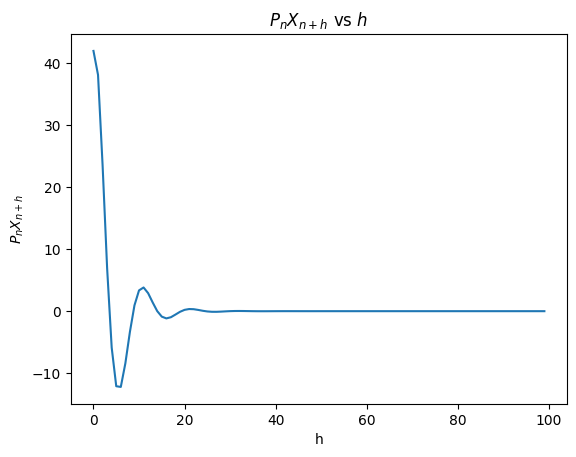

In [262]:
plt.plot(mu_n)  # Plot y=sigma_n**2 against x=h
plt.title("$P_n X_{n+h}$ vs $h$")
plt.xlabel("h")  # Label for x-axis if needed
plt.ylabel("$P_n X_{n+h}$")  # Label for y-axis if needed
plt.show()